In [1]:
import pandas as pd
import numpy as np
import matplotlib as plt

In [2]:
df = pd.DataFrame({'name': ['Ann', 'Ann', 'Ann', 'Bob', 'Bob'], 
                   'destination': ['Japan', 'Korea', 'Switzerland', 
                                   'USA', 'Switzerland'], 
                   'dep_date': ['2019-02-02', '2019-01-01', 
                                '2020-01-11', '2019-05-05', 
                                '2020-01-11'], 
                   'duration': [7, 21, 14, 10, 14]})
df

,name,destination,dep_date,duration
0,Ann,Japan,2019-02-02,7
1,Ann,Korea,2019-01-01,21
2,Ann,Switzerland,2020-01-11,14
3,Bob,USA,2019-05-05,10
4,Bob,Switzerland,2020-01-11,14


We will start with the basic versions of LEAD() and LAG(). For each trip, let’s pull the departure date of the next trip: lead1, the second next trip: lead2, the previous trip: lag1 and the third previous trip: lag3.

In [3]:
df.sort_values(['dep_date', 'name'], inplace=True)
df.assign(lead1 = df['dep_date'].shift(-1),
          lead2 = df['dep_date'].shift(-2),
          lag1 = df['dep_date'].shift(),
          lag3 = df['dep_date'].shift(3))

,name,destination,dep_date,duration,lead1,lead2,lag1,lag3
1,Ann,Korea,2019-01-01,21,2019-02-02,2019-05-05,NaN,NaN
0,Ann,Japan,2019-02-02,7,2019-05-05,2020-01-11,2019-01-01,NaN
3,Bob,USA,2019-05-05,10,2020-01-11,2020-01-11,2019-02-02,NaN
2,Ann,Switzerland,2020-01-11,14,2020-01-11,NaN,2019-05-05,2019-01-01
4,Bob,Switzerland,2020-01-11,14,NaN,NaN,2020-01-11,2019-02-02


In the first line, we sorted the data with sort_values() once in place since we are using the same logic for all shifting operations. Doing it this way is more efficient than sorting the data every time we create a new column like below:

In [4]:
df.assign(lead1 = df.sort_values(['dep_date', 'name'])['dep_date']
                    .shift(-1),
          lead2 = df.sort_values(['dep_date', 'name'])['dep_date']
                    .shift(-2),
          lag1 = df.sort_values(['dep_date', 'name'])['dep_date']
                   .shift(),
          lag3 = df.sort_values(['dep_date', 'name'])['dep_date']
                   .shift(3))

,name,destination,dep_date,duration,lead1,lead2,lag1,lag3
1,Ann,Korea,2019-01-01,21,2019-02-02,2019-05-05,NaN,NaN
0,Ann,Japan,2019-02-02,7,2019-05-05,2020-01-11,2019-01-01,NaN
3,Bob,USA,2019-05-05,10,2020-01-11,2020-01-11,2019-02-02,NaN
2,Ann,Switzerland,2020-01-11,14,2020-01-11,NaN,2019-05-05,2019-01-01
4,Bob,Switzerland,2020-01-11,14,NaN,NaN,2020-01-11,2019-02-02


Now, let’s look at how to manipulate date/datetime columns.

we will extract day name of the week from departure date: day, name of the month from departure date: month, number of days elapsed since previous trip: diff and arrival date: arr_date.

In [5]:
# Convert to proper dtype
df['dep_date'] = pd.to_datetime(df['dep_date'])
df['duration'] = pd.to_timedelta(df['duration'], 'D')

SELECT name
       , destination
       , dep_date
       , duration
       , DATENAME(WEEKDAY, dep_date) AS day
       , DATENAME(MONTH, dep_date) AS month
       , DATEDIFF(DAY,  
                  LAG(dep_date) OVER(ORDER BY dep_date, name), 
                  dep_date) AS diff
       , DATEADD(DAY, day, dep_date) AS arr_date
FROM df

Converting dep_date to datetime will allow us to access many date parts with the .dt accessor. For instance: df[‘dep_date’].dt.year will give us the year (equivalent to DATEPART(YEAR, dep_date) in SQL).
Converting duration to timedelta allows us to add it to a datetime column to get another datetime column.

In [6]:
df.sort_values(['dep_date', 'name'], inplace=True)
df.assign(day = df['dep_date'].dt.day_name(),
          month = df['dep_date'].dt.month_name(),
          diff = df['dep_date'] - df['dep_date'].shift(),
          arr_date = df['dep_date'] + df['duration'])

,name,destination,dep_date,duration,day,month,diff,arr_date
1,Ann,Korea,2019-01-01,21 days,Tuesday,January,NaT,2019-01-22
0,Ann,Japan,2019-02-02,7 days,Saturday,February,32 days,2019-02-09
3,Bob,USA,2019-05-05,10 days,Sunday,May,92 days,2019-05-15
2,Ann,Switzerland,2020-01-11,14 days,Saturday,January,251 days,2020-01-25
4,Bob,Switzerland,2020-01-11,14 days,Saturday,January,0 days,2020-01-25


As you can see, the manipulation is simple once the data types are correctly set. Of note, we can check the data types of columns with the dtypes attribute of a DataFrame. Here’s an example:

In [7]:
df.sort_values(['dep_date', 'name'], inplace=True)
df.assign(day = df['dep_date'].dt.day_name(),
          month = df['dep_date'].dt.month_name(),
          diff = df['dep_date'] - df['dep_date'].shift(),
          arr_date = df['dep_date'] + df['duration']).dtypes

name                    object
destination             object
dep_date        datetime64[ns]
duration       timedelta64[ns]
day                     object
month                   object
diff           timedelta64[ns]
arr_date        datetime64[ns]
dtype: object

In pandas, when finding the difference between two dates, it returns a timedelta column. Therefore, we can see that column diff is actually a timedelta.

Ranking: ROW_NUMBER(), RANK(), DENSE_RANK()
You may have used at least one of these functions before in SQL. The key difference between these three is their treatment in ranking ties and ranks thereafter. Let’s create three columns that rank each record based on duration using each of these method: row_number_d, rank_d and dense_rank_d.
When using ROW_NUMBER(), ties are given a different rank unlike the other two. To control how ties are treated with ROW_NUMBER(), we used name to breaks ties.

SELECT name
       , destination
       , dep_date
       , duration
       , ROW_NUMBER() OVER(ORDER BY duration, name) AS row_number_d
       , RANK() OVER(ORDER BY duration) AS rank_d
       , DENSE_RANK() OVER(ORDER BY duration) AS dense_rank_d
FROM df

In [8]:
df.sort_values(['duration', 'name']).assign(
    row_number_d = df['duration'].rank(method='first').astype(int),
    rank_d = df['duration'].rank(method='min').astype(int),
    dense_rank_d = df['duration'].rank(method='dense').astype(int))

,name,destination,dep_date,duration,row_number_d,rank_d,dense_rank_d
0,Ann,Japan,2019-02-02,7 days,1,1,1
3,Bob,USA,2019-05-05,10 days,2,2,2
2,Ann,Switzerland,2020-01-11,14 days,3,3,3
4,Bob,Switzerland,2020-01-11,14 days,4,3,3
1,Ann,Korea,2019-01-01,21 days,5,5,4


You may have also noticed that we have included astype(int). This is to convert the ranks in floats to integers. If you prefer to see floats, then that portion of the code could be removed:
df.sort_values(['duration', 'name']).assign(
    row_number_d = df['duration'].rank(method='first'),
    rank_d = df['duration'].rank(method='min'),
    dense_rank_d = df['duration'].rank(method='dense'))

we will create column for the longest trip duration: max_dur, total duration for all trips: sum_dur, average duration of trip per person: avg_dur_name and cumulative sum of trip length for each person: cum_sum_dur_name.

SELECT name
       , destination
       , dep_date 
       , duration
       , MAX(duration) OVER() AS max_dur
       , SUM(duration) OVER() AS sum_dur
       , AVG(duration) OVER(PARTITION BY name) AS avg_dur_name
       , SUM(duration) OVER(PARTITION BY name ORDER BY dep_date
                            RANGE BETWEEN UNBOUNDED PRECEDING
                            AND CURRENT ROW) AS cum_sum_dur_name
FROM df

SELECT ROW_NUMBER() OVER(PARTITION BY name 
                         ORDER BY dep_date) AS number
       , name
       , destination
       , DATENAME(MONTH, dep_date) AS dep_month
       , dep_date
       , DATEADD(DAY, duration, dep_date) AS arr_date
       , LEAD(dep_date) OVER(PARTITION BY NAME 
                             ORDER BY dep_date) AS next_dep_date
       , DATEDIFF(DAY, 
                  dep_date, 
                  LEAD(dep_date) OVER(PARTITION BY NAME 
                                      ORDER BY dep_date)) AS gap
       , duration
       , AVG(1.0 * duration) OVER() AS avg_dur
       , AVG(1.0 * duration) OVER(PARTITION BY name) AS avg_dur_name
       , SUM(duration) OVER(PARTITION BY name ORDER BY dep_date
                            RANGE BETWEEN UNBOUNDED PRECEDING 
                            AND CURRENT ROW) AS cum_sum_dur_name   
FROM df
ORDER BY name, dep_date

In [15]:
# Convert to proper type
df['dep_date'] = pd.to_datetime(df['dep_date'])
df['duration'] = pd.to_timedelta(df['duration'], 'D')
# Sort data
df.sort_values(['name', 'dep_date'], inplace=True)
# Append new columns to data
df = df.assign(number=df.groupby('name')['dep_date']
                        .rank('min')
                        .astype(int),
               dep_month = df['dep_date'].dt.month_name(),
               arr_date = df['dep_date'] + df['duration'],
               next_dep_date = df.groupby('name')['dep_date']
                                 .transform(lambda x: x.shift(-1)),
               gap = df.groupby('name')['dep_date']
                       .transform(lambda x: x.shift(-1))-
                                            df['dep_date'],
               avg_dur = df['duration'].mean(),
               avg_dur_name = df.groupby('name')['duration']
                                .transform(lambda x: x.mean()),
               cum_sum_dur_name = df.groupby('name')['duration']
                                   .transform(lambda x: x.cumsum()))
# Reorder columns
columns = ['number', 'name', 'destination', 'dep_month', 
           'dep_date', 'arr_date', 'next_dep_date', 
           'gap', 'duration', 'avg_dur', 'avg_dur_name', 
           'cum_sum_dur_name']
df[columns]

,number,name,destination,dep_month,dep_date,arr_date,next_dep_date,gap,duration,avg_dur,avg_dur_name,cum_sum_dur_name
1,1,Ann,Korea,January,2019-01-01,2019-01-22,2019-02-02,32 days,21 days,13 days 04:48:00,14 days,21 days
0,2,Ann,Japan,February,2019-02-02,2019-02-09,2020-01-11,343 days,7 days,13 days 04:48:00,14 days,28 days
2,3,Ann,Switzerland,January,2020-01-11,2020-01-25,NaT,NaT,14 days,13 days 04:48:00,14 days,42 days
3,1,Bob,USA,May,2019-05-05,2019-05-15,2020-01-11,251 days,10 days,13 days 04:48:00,12 days,10 days
4,2,Bob,Switzerland,January,2020-01-11,2020-01-25,NaT,NaT,14 days,13 days 04:48:00,12 days,24 days


Description
One waiter recorded information about each tip he received over a period of a few months working in one restaurant. He collected several variables:

Usage
tips
Format
A data frame with 244 rows and 7 variables

Details
tip in dollars,

bill in dollars,

sex of the bill payer,

whether there were smokers in the party,

day of the week,

time of day,

size of the party.

In [2]:
# Import packages
import pandas as pd
import seaborn as sns
# Import data 
tips = sns.load_dataset('tips')
tips.head()

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4


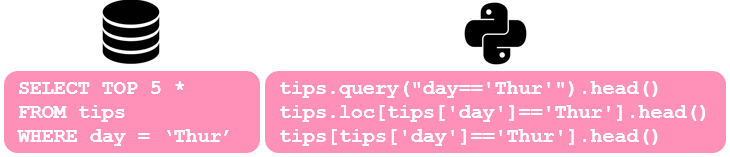

In [3]:
tips.query("day=='Thur'").head()
tips.loc[tips['day']=='Thur'].head()
tips[tips['day']=='Thur'].head()

,total_bill,tip,sex,smoker,day,time,size
77,27.20,4.00,Male,No,Thur,Lunch,4
78,22.76,3.00,Male,No,Thur,Lunch,2
79,17.29,2.71,Male,No,Thur,Lunch,2
80,19.44,3.00,Male,Yes,Thur,Lunch,2
81,16.66,3.40,Male,No,Thur,Lunch,2


We could achieve the same in pandas with one of three ways shown. The first one is my favourite way to filter data in pandas because it’s more succinct especially when there are multiple conditions to filter. In the other two methods, we filter the data with a boolean mask, which is represented in tips['day']=='Thur' part of the code. This boolean mask will create a boolean value for each record where it is True if the record is from Thursday otherwise False. Because the last two methods are identical except for .loc part, I will show examples only for the latter as the former could be easily inferred from the other. Did you notice that we used == for equality? That’s because = is reserved for assignment in Python. However, >,>=,< and <= work the same way in both. Now, let’s look at some other operators:

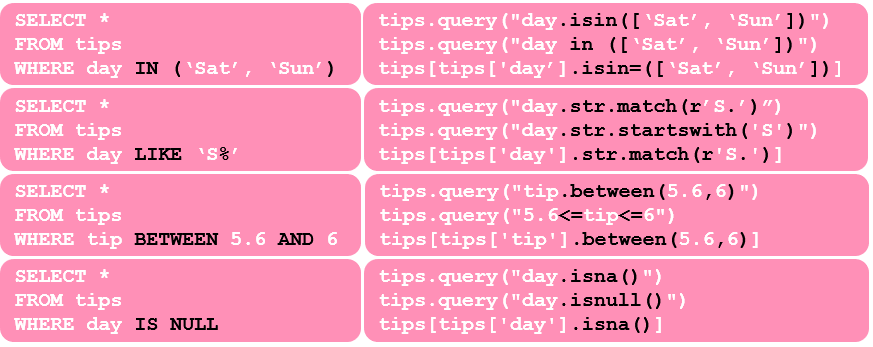

In [12]:
tips.query("day.isin(['Sat', 'Sun'])")
tips.query("day in(['Sat', 'Sun'])")
#tips[tips['day'].isin=(['Sat', 'Sun'])]

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4
...,...,...,...,...,...,...,...
238,35.83,4.67,Female,No,Sat,Dinner,3
239,29.03,5.92,Male,No,Sat,Dinner,3
240,27.18,2.00,Female,Yes,Sat,Dinner,2
241,22.67,2.00,Male,Yes,Sat,Dinner,2


As you can see, there are similarities in keywords between the two. One thing to remember is that Python is case sensitive. This means match(r'S.') and match(r's.') will give us different outputs while LIKE 'S%' or LIKE 's%' in SQL will return the same output. If we want to filter any days starting with ‘s’ regardless of the case, one way to to achieve that is to use match(r'[Ss]'). If we had a weekday named ‘S’ for some records, WHERE day LIKE ‘S%' and .str.startswith(‘S') will pick these cases while .str.match(r'S.') will not. If we wanted to cater for this kind of cases, then we will modify the script to .str.match(r'S.?'). Now, let’s look at negations:

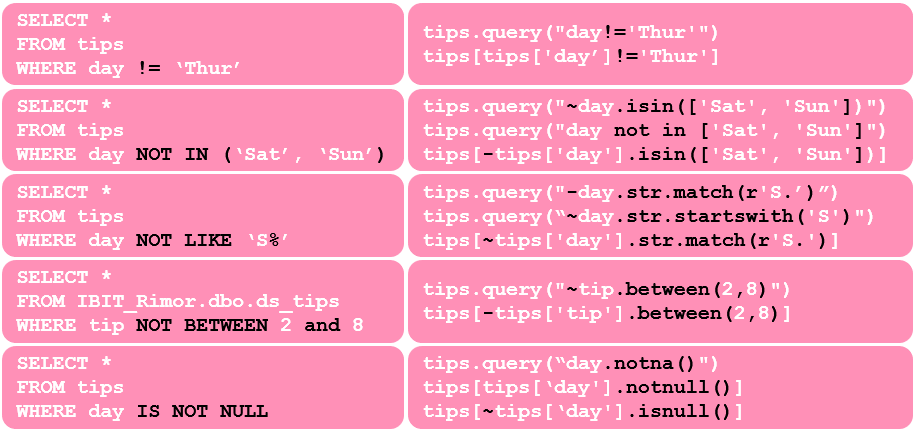

In [13]:
tips.query("day!='Thur'")
tips[tips['day']!='Thur']

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4
...,...,...,...,...,...,...,...
238,35.83,4.67,Female,No,Sat,Dinner,3
239,29.03,5.92,Male,No,Sat,Dinner,3
240,27.18,2.00,Female,Yes,Sat,Dinner,2
241,22.67,2.00,Male,Yes,Sat,Dinner,2


You may already noticed that equivalent of NOT in SQL is either - or ~ in pandas. Now, let’s see how to filter with multiple conditions with AND or OR:

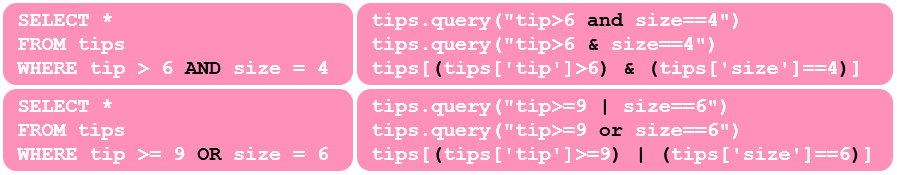

In [14]:
tips.query("tip>6 and size==4")
tips.query("tip>6 & size==4")
tips[(tips['tip']>6) & (tips['size']==4)]

,total_bill,tip,sex,smoker,day,time,size
23,39.42,7.58,Male,No,Sat,Dinner,4
59,48.27,6.73,Male,No,Sat,Dinner,4
183,23.17,6.50,Male,Yes,Sun,Dinner,4
212,48.33,9.00,Male,No,Sat,Dinner,4


In [15]:
tips.query("tip>=9 | size==6")
tips.query("tip>=9 or size==6")
tips[(tips['tip']>=9) | (tips['size']==6)]

,total_bill,tip,sex,smoker,day,time,size
125,29.80,4.2,Female,No,Thur,Lunch,6
141,34.30,6.7,Male,No,Thur,Lunch,6
143,27.05,5.0,Female,No,Thur,Lunch,6
156,48.17,5.0,Male,No,Sun,Dinner,6
170,50.81,10.0,Male,Yes,Sat,Dinner,3
212,48.33,9.0,Male,No,Sat,Dinner,4


In Python, and or or are known as boolean operators whereas & or | are considered as bitwise operators.
As you can see, filtering with query is more concise than boolean masks. It is also more flexible because we can use either boolean or bitwise operators. On the other hand, when filtering with boolean masks, only bitwise operators are supported. That is tips[(tips['tip']>=9) or (tips['size']==6)] will give an error. If you want to know why, have a look at this thread on StackOverFlow.
However, when using query() depending on your version of pandas, you may encounter an issue described here: TypeError: ‘Series’ objects are mutable, thus they cannot be hashed. If this happens, use the alternative filtering method using boolean mask instead.


Let’s now see how to sort the data by one column in an ascending order:

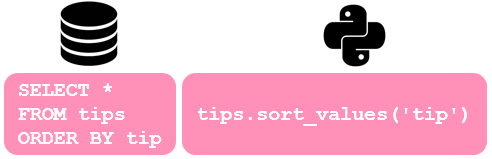


In [16]:
tips.sort_values('tip')

,total_bill,tip,sex,smoker,day,time,size
67,3.07,1.00,Female,Yes,Sat,Dinner,1
236,12.60,1.00,Male,Yes,Sat,Dinner,2
92,5.75,1.00,Female,Yes,Fri,Dinner,2
111,7.25,1.00,Female,No,Sat,Dinner,1
0,16.99,1.01,Female,No,Sun,Dinner,2
...,...,...,...,...,...,...,...
141,34.30,6.70,Male,No,Thur,Lunch,6
59,48.27,6.73,Male,No,Sat,Dinner,4
23,39.42,7.58,Male,No,Sat,Dinner,4
212,48.33,9.00,Male,No,Sat,Dinner,4


Just like we could use ORDER BY tip ASC in SQL, we could use tips.sort_values(tip’, ascending=True) in pandas. However, I find these extra verbosity redundant. If we were to sort in descending order, we use:
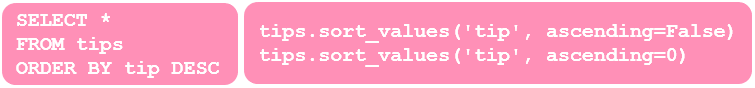

In [17]:
tips.sort_values('tip', ascending=False)
tips.sort_values('tip', ascending=0)

,total_bill,tip,sex,smoker,day,time,size
170,50.81,10.00,Male,Yes,Sat,Dinner,3
212,48.33,9.00,Male,No,Sat,Dinner,4
23,39.42,7.58,Male,No,Sat,Dinner,4
59,48.27,6.73,Male,No,Sat,Dinner,4
141,34.30,6.70,Male,No,Thur,Lunch,6
...,...,...,...,...,...,...,...
0,16.99,1.01,Female,No,Sun,Dinner,2
236,12.60,1.00,Male,Yes,Sat,Dinner,2
111,7.25,1.00,Female,No,Sat,Dinner,1
67,3.07,1.00,Female,Yes,Sat,Dinner,1


See how boolean value could also be represented by an integer? Let’s see how to sort by multiple columns:
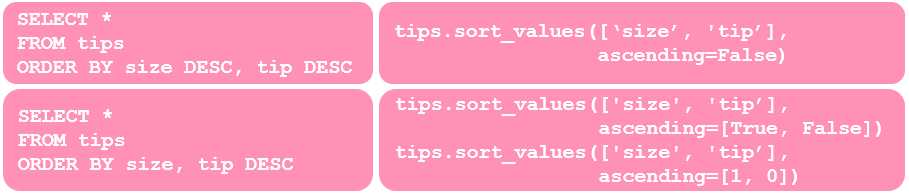    

In [18]:
tips.sort_values(['size', 'tip'], ascending=False)

,total_bill,tip,sex,smoker,day,time,size
141,34.30,6.70,Male,No,Thur,Lunch,6
143,27.05,5.00,Female,No,Thur,Lunch,6
156,48.17,5.00,Male,No,Sun,Dinner,6
125,29.80,4.20,Female,No,Thur,Lunch,6
155,29.85,5.14,Female,No,Sun,Dinner,5
...,...,...,...,...,...,...,...
236,12.60,1.00,Male,Yes,Sat,Dinner,2
222,8.58,1.92,Male,Yes,Fri,Lunch,1
82,10.07,1.83,Female,No,Thur,Lunch,1
67,3.07,1.00,Female,Yes,Sat,Dinner,1


In [19]:
tips.sort_values(['size', 'tip'], ascending=[True, False])

,total_bill,tip,sex,smoker,day,time,size
222,8.58,1.92,Male,Yes,Fri,Lunch,1
82,10.07,1.83,Female,No,Thur,Lunch,1
67,3.07,1.00,Female,Yes,Sat,Dinner,1
111,7.25,1.00,Female,No,Sat,Dinner,1
88,24.71,5.85,Male,No,Thur,Lunch,2
...,...,...,...,...,...,...,...
187,30.46,2.00,Male,Yes,Sun,Dinner,5
141,34.30,6.70,Male,No,Thur,Lunch,6
143,27.05,5.00,Female,No,Thur,Lunch,6
156,48.17,5.00,Male,No,Sun,Dinner,6


In [20]:
tips.sort_values(['size', 'tip'], ascending=[1, 0])

,total_bill,tip,sex,smoker,day,time,size
222,8.58,1.92,Male,Yes,Fri,Lunch,1
82,10.07,1.83,Female,No,Thur,Lunch,1
67,3.07,1.00,Female,Yes,Sat,Dinner,1
111,7.25,1.00,Female,No,Sat,Dinner,1
88,24.71,5.85,Male,No,Thur,Lunch,2
...,...,...,...,...,...,...,...
187,30.46,2.00,Male,Yes,Sun,Dinner,5
141,34.30,6.70,Male,No,Thur,Lunch,6
143,27.05,5.00,Female,No,Thur,Lunch,6
156,48.17,5.00,Male,No,Sun,Dinner,6


Aggregate data
Often, we want to aggregate the data and examine summary measures, let’s start with the most basic one. This is how to check the number of rows:
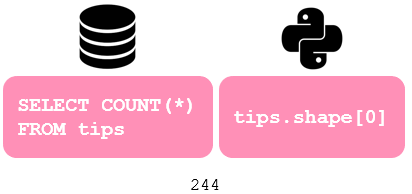

In [25]:
tips.shape

(244, 7)

In [21]:
tips.shape[0]

244

In pandas, if we run tips.shape, it will show us both number of rows and columns in this format: (#rows, #columns). Here, we are only filtering in the number of rows by adding [0]. Another common aggregation is to find summary statistics. Let’s check the mean for all numeric columns:
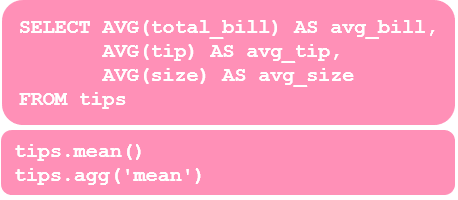

In [24]:
tips.mean()
tips.agg('mean')

total_bill    19.785943
tip            2.998279
size           2.569672
dtype: float64

With either of these two options in pandas, all numerical columns will automatically be picked up if the data is in the right type. Therefore, we didn’t have to type all the column names.
It’s worth noting that agg is actually an alias for aggregate. Therefore, the second option shown is a short form of tips.aggregate('mean').
Let’s now inspect minimum and maximum values for a column:
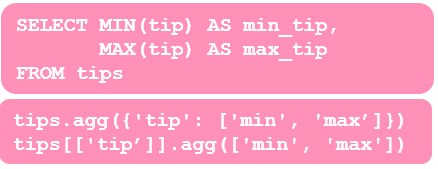

In [26]:
tips.agg({'tip' : ['min', 'max']})

,tip
min,1.0
max,10.0


In [27]:
tips[['tip']].agg(['min', 'max'])

,tip
min,1.0
max,10.0


Again, either of these options works. Let’s extend the query further:
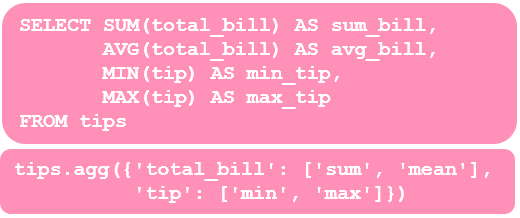

In [28]:
tips.agg({'total_bill': ['sum', 'mean'], 'tip': ['min', 'max']})

,total_bill,tip
max,NaN,10.0
mean,19.785943,NaN
min,NaN,1.0
sum,4827.770000,NaN


Although the output of these in SQL and pandas are not exactly identical, we get the same summary statistics in slightly different formats. This is how we would extract the same summary statistics for both columns:
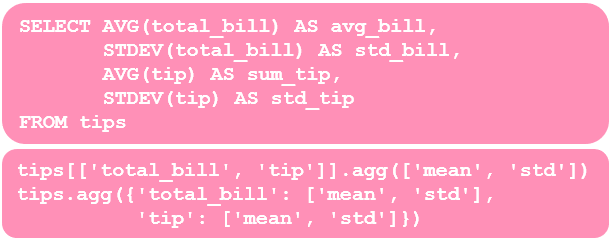

In [29]:
tips[['total_bill' , 'tip']].agg(['mean', 'std'])

,total_bill,tip
mean,19.785943,2.998279
std,8.902412,1.383638


In [30]:
tips.agg({'total_bill':['mean', 'std'], 'tip': ['mean', 'std']})

,total_bill,tip
mean,19.785943,2.998279
std,8.902412,1.383638


Another common query is to check unique values for a column:
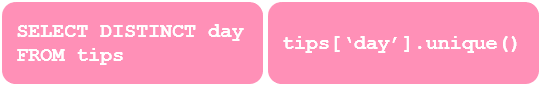

In [31]:
tips['day'].unique()

['Sun', 'Sat', 'Thur', 'Fri']
Categories (4, object): ['Sun', 'Sat', 'Thur', 'Fri']

If we want to see the number of unique values instead, then it changes to:
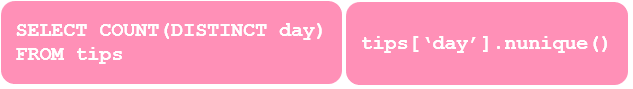

In [32]:
tips['day'].nunique()

4

In pandas, we can also get summary statistics using describe(). If we run tips.describe(), we will see a nice table of summary statistics for all numerical columns.

In [33]:
tips.describe()

,total_bill,tip,size
count,244.000000,244.000000,244.000000
mean,19.785943,2.998279,2.569672
std,8.902412,1.383638,0.951100
min,3.070000,1.000000,1.000000
25%,13.347500,2.000000,2.000000
50%,17.795000,2.900000,2.000000
75%,24.127500,3.562500,3.000000
max,50.810000,10.000000,6.000000


Aggregate data by group
Let’s look at a simple group aggregation example first:
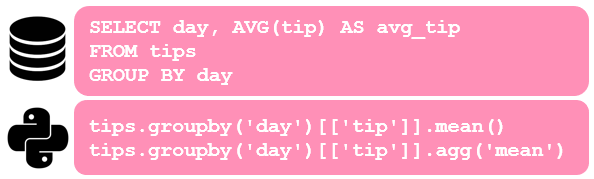    

In [34]:
tips.groupby('day')[['tip']].mean()

,tip
day,
Thur,2.771452
Fri,2.734737
Sat,2.993103
Sun,3.255132


In [35]:
tips.groupby('day')[['tip']].agg('mean')

,tip
day,
Thur,2.771452
Fri,2.734737
Sat,2.993103
Sun,3.255132


Another example:
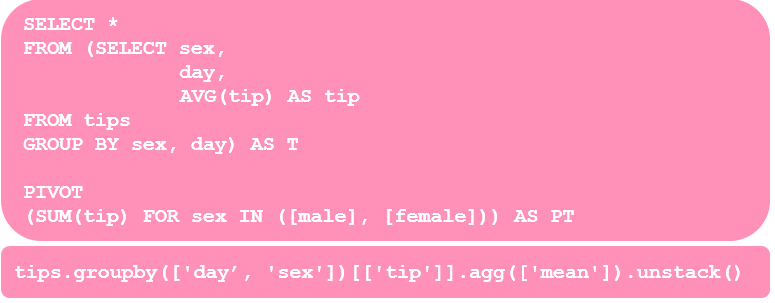

In [36]:
tips.groupby(['day', 'sex'])[['tip']].agg(['mean']).unstack()

tip          
          mean          
sex       Male    Female
day                     
Thur  2.980333  2.575625
Fri   2.693000  2.781111
Sat   3.083898  2.801786
Sun   3.220345  3.367222

Does making pivot table look easier in pandas? Maybe? 👀 We can also use what we have learned in the aggregation section with group aggregation too.
Voila❕ These were the comparisons for 5 types of queries. Here is a bonus example where we combine some of the queries:
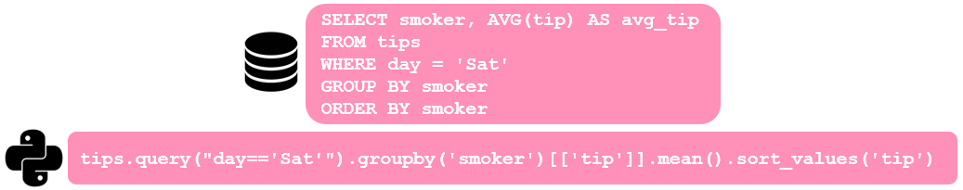

In [37]:
tips.query("day=='sat'").groupby('smoker')[['tip']].mean().sort_values('tip')

,tip
smoker,
Yes,NaN
No,NaN


A popular Python library used by those working with data is pandas, an easy and flexible data manipulation and analysis library. There are a myriad of awesome methods and functions in pandas, some of which are probably less well-known than others. With this in mind, I have 5 tips on how these less common (at least in my opinion) methods and functions may be useful in case you don’t already know them 🐼 :

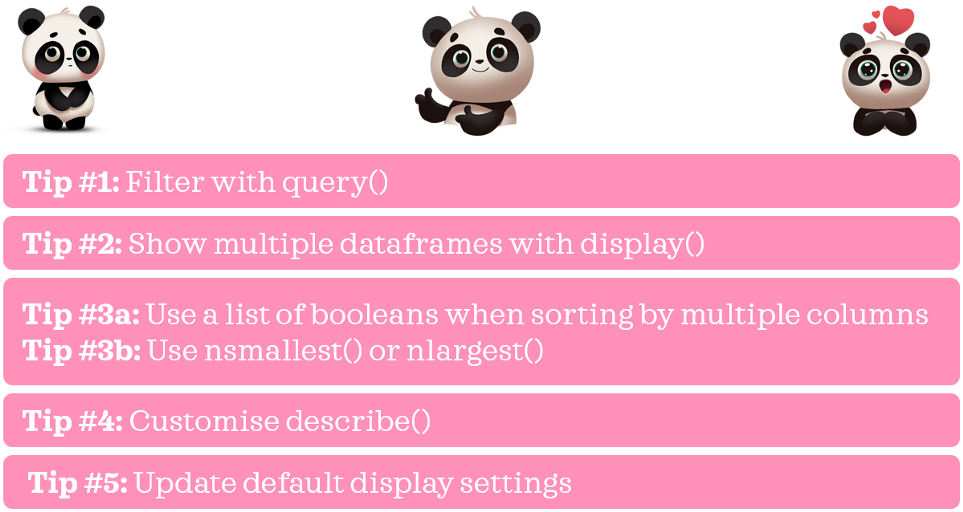

We will use seaborn’s dataset on tips to exemplify my tips. See what I did there

In [40]:
# Import packages
import pandas as pd
import seaborn as sns
# Import data 
df = sns.load_dataset('tips')
print(f"{df.shape[0]} rows and {df.shape[1]} columns")
df.head()

244 rows and 7 columns


,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4


Filter with query()
Let’s start with my favourite tip! Say we wanted to filter the data to those who tipped more than $6 with $30+ total bill. One common way to accomplish this is to use:

In [41]:
df.loc[(df['tip']>6) & (df['total_bill']>=30)]

,total_bill,tip,sex,smoker,day,time,size
23,39.42,7.58,Male,No,Sat,Dinner,4
59,48.27,6.73,Male,No,Sat,Dinner,4
141,34.30,6.70,Male,No,Thur,Lunch,6
170,50.81,10.00,Male,Yes,Sat,Dinner,3
212,48.33,9.00,Male,No,Sat,Dinner,4


This does the job, but don’t you think it’s little too verbose: each condition requires reference to the dataframe and a parenthesis wrapping if there are multiple conditions. Now, let me show you how we could achieve the same outcome with more elegant code with query():

In [42]:
df.query("tip>6 & total_bill>=30")

,total_bill,tip,sex,smoker,day,time,size
23,39.42,7.58,Male,No,Sat,Dinner,4
59,48.27,6.73,Male,No,Sat,Dinner,4
141,34.30,6.70,Male,No,Thur,Lunch,6
170,50.81,10.00,Male,Yes,Sat,Dinner,3
212,48.33,9.00,Male,No,Sat,Dinner,4


You see how clean, simple and readable this looks? We are not repeatedly typing df or overloading with brackets and parentheses anymore. With less keystrokes, it’s also quicker to write code and code will be less prone to mistakes. A few more additional tips on query():

In [45]:
# reference global variable name with @
median_tip = df['tip'].median()
display(df.query("tip>@median_tip").head())

# wrap column name containing . with backtick: `
df.rename(columns={'total_bill':'total.bill'}, inplace=True)
display(df.query("`total.bill`<20").head())
df.rename(columns={'total.bill':'total_bill'}, inplace=True)

# wrap string condition with single quotes (this is what I like)
display(df.query("day=='Sat'").head())
# could also do it the other way around (i.e. 'day=="Sat"')


,total_bill,tip,sex,smoker,day,time,size
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4
5,25.29,4.71,Male,No,Sun,Dinner,4
7,26.88,3.12,Male,No,Sun,Dinner,4


,total.bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
6,8.77,2.00,Male,No,Sun,Dinner,2
8,15.04,1.96,Male,No,Sun,Dinner,2
9,14.78,3.23,Male,No,Sun,Dinner,2


,total_bill,tip,sex,smoker,day,time,size
19,20.65,3.35,Male,No,Sat,Dinner,3
20,17.92,4.08,Male,No,Sat,Dinner,2
21,20.29,2.75,Female,No,Sat,Dinner,2
22,15.77,2.23,Female,No,Sat,Dinner,2
23,39.42,7.58,Male,No,Sat,Dinner,4


Show multiple dataframes with display()
I have already given this away in the previous code, so you could probably guess what this one is about. Assume we wanted to inspect both head and tail of the df in one cell of Jupyter Notebook. If we run the following code, it will only show the tail:

In [46]:
df.head()
df.tail()

,total_bill,tip,sex,smoker,day,time,size
239,29.03,5.92,Male,No,Sat,Dinner,3
240,27.18,2.00,Female,Yes,Sat,Dinner,2
241,22.67,2.00,Male,Yes,Sat,Dinner,2
242,17.82,1.75,Male,No,Sat,Dinner,2
243,18.78,3.00,Female,No,Thur,Dinner,2


We can get around this with display():

In [47]:
display(df.head())
display(df.tail())

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4


,total_bill,tip,sex,smoker,day,time,size
239,29.03,5.92,Male,No,Sat,Dinner,3
240,27.18,2.00,Female,Yes,Sat,Dinner,2
241,22.67,2.00,Male,Yes,Sat,Dinner,2
242,17.82,1.75,Male,No,Sat,Dinner,2
243,18.78,3.00,Female,No,Thur,Dinner,2


In the last line, display() is redundant but it is there for consistency. It works the same way if we take out display() from the last line:

In [48]:
display(df.head())
df.tail()

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4


,total_bill,tip,sex,smoker,day,time,size
239,29.03,5.92,Male,No,Sat,Dinner,3
240,27.18,2.00,Female,Yes,Sat,Dinner,2
241,22.67,2.00,Male,Yes,Sat,Dinner,2
242,17.82,1.75,Male,No,Sat,Dinner,2
243,18.78,3.00,Female,No,Thur,Dinner,2


Use a list of booleans when sorting by multiple columns
I have two tips on sorting. The first one is for sorting multiple columns.
Have you ever had to sort your data with multiple columns in different directions? Here is an example of what I mean: Sort the data by total bill in ascending order and break ties with amount of tip in descending order.
Before I knew tip #3a, I would create an interim column to flip the scale of either total bill or tip to make all the relevant columns to have the same direction and sort afterwards (I have flipped tip in this example):

In [49]:
df['rev_tip'] = -df['tip']
df.sort_values(by=['total_bill', 'rev_tip'], ascending=True).head()

,total_bill,tip,sex,smoker,day,time,size,rev_tip
67,3.07,1.00,Female,Yes,Sat,Dinner,1,-1.00
92,5.75,1.00,Female,Yes,Fri,Dinner,2,-1.00
172,7.25,5.15,Male,Yes,Sun,Dinner,2,-5.15
111,7.25,1.00,Female,No,Sat,Dinner,1,-1.00
149,7.51,2.00,Male,No,Thur,Lunch,2,-2.00


This is a workaround but not very elegant way to tackle the task. Let’s delete rev_tip with del df['rev_tip']. Instead, we could pass a list of booleans to indicate the order for each variable for sorting:

In [51]:
del df['rev_tip']

In [53]:
df.sort_values(by=['total_bill', 'tip'], ascending=[True, False]).head()

,total_bill,tip,sex,smoker,day,time,size
67,3.07,1.00,Female,Yes,Sat,Dinner,1
92,5.75,1.00,Female,Yes,Fri,Dinner,2
172,7.25,5.15,Male,Yes,Sun,Dinner,2
111,7.25,1.00,Female,No,Sat,Dinner,1
149,7.51,2.00,Male,No,Thur,Lunch,2


Not only do we not need to create an extra column, the last code also looks cleaner and more readable.
It’s also possible to use the numerical representation of booleans. That is, if we change to ascending =[1,0], it will also give us the same output.

Use nsmallest() or nlargest()
This second tip will come in handy if you ever had to quickly check out data extract for records that have the smallest or largest values in a particular column. Using nsmallest(), we could check out 5 records with the smallest total bill like this:

In [54]:
df.nsmallest(5, 'total_bill')

,total_bill,tip,sex,smoker,day,time,size
67,3.07,1.00,Female,Yes,Sat,Dinner,1
92,5.75,1.00,Female,Yes,Fri,Dinner,2
111,7.25,1.00,Female,No,Sat,Dinner,1
172,7.25,5.15,Male,Yes,Sun,Dinner,2
149,7.51,2.00,Male,No,Thur,Lunch,2


This is a short form for:

In [55]:
df.sort_values(by='total_bill').head()

,total_bill,tip,sex,smoker,day,time,size
67,3.07,1.00,Female,Yes,Sat,Dinner,1
92,5.75,1.00,Female,Yes,Fri,Dinner,2
111,7.25,1.00,Female,No,Sat,Dinner,1
172,7.25,5.15,Male,Yes,Sun,Dinner,2
149,7.51,2.00,Male,No,Thur,Lunch,2


Similarly, the outputs of these two lines are identical:

In [56]:
display(df.nlargest(5, 'total_bill'))


,total_bill,tip,sex,smoker,day,time,size
170,50.81,10.00,Male,Yes,Sat,Dinner,3
212,48.33,9.00,Male,No,Sat,Dinner,4
59,48.27,6.73,Male,No,Sat,Dinner,4
156,48.17,5.00,Male,No,Sun,Dinner,6
182,45.35,3.50,Male,Yes,Sun,Dinner,3


In [57]:
display(df.sort_values(by='total_bill', ascending=False).head())

,total_bill,tip,sex,smoker,day,time,size
170,50.81,10.00,Male,Yes,Sat,Dinner,3
212,48.33,9.00,Male,No,Sat,Dinner,4
59,48.27,6.73,Male,No,Sat,Dinner,4
156,48.17,5.00,Male,No,Sun,Dinner,6
182,45.35,3.50,Male,Yes,Sun,Dinner,3


Customise describe()
Any pandas user is probably familiar with df.describe(). This shows summary stats for numerical columns. But we can get more than that by specifying its arguments.
Firstly, let’s check out the column types:

In [58]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244 entries, 0 to 243
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   total_bill  244 non-null    float64 
 1   tip         244 non-null    float64 
 2   sex         244 non-null    category
 3   smoker      244 non-null    category
 4   day         244 non-null    category
 5   time        244 non-null    category
 6   size        244 non-null    int64   
dtypes: category(4), float64(2), int64(1)
memory usage: 7.0 KB


In our dataframe, we have numerical and categorical columns. Let’s see summary stats for all columns by adding include='all':


In [59]:
df.describe(include='all')

,total_bill,tip,sex,smoker,day,time,size
count,244.000000,244.000000,244,244,244,244,244.000000
unique,NaN,NaN,2,2,4,2,NaN
top,NaN,NaN,Male,No,Sat,Dinner,NaN
freq,NaN,NaN,157,151,87,176,NaN
mean,19.785943,2.998279,NaN,NaN,NaN,NaN,2.569672
std,8.902412,1.383638,NaN,NaN,NaN,NaN,0.951100
min,3.070000,1.000000,NaN,NaN,NaN,NaN,1.000000
25%,13.347500,2.000000,NaN,NaN,NaN,NaN,2.000000
50%,17.795000,2.900000,NaN,NaN,NaN,NaN,2.000000
75%,24.127500,3.562500,NaN,NaN,NaN,NaN,3.000000


This is cool but a little messy. Let’s show the summary stats by column types separately with the following script:


In [60]:
display(df.describe(include=['category'])) # categorical types
display(df.describe(include=['number'])) # numerical types

,sex,smoker,day,time
count,244,244,244,244
unique,2,2,4,2
top,Male,No,Sat,Dinner
freq,157,151,87,176


,total_bill,tip,size
count,244.000000,244.000000,244.000000
mean,19.785943,2.998279,2.569672
std,8.902412,1.383638,0.951100
min,3.070000,1.000000,1.000000
25%,13.347500,2.000000,2.000000
50%,17.795000,2.900000,2.000000
75%,24.127500,3.562500,3.000000
max,50.810000,10.000000,6.000000


Do you like this better? If we had both strings and categorical columns and wished to display the summary stats for both in one table, we can use either: include=['category', 'object'] or exclude=['number']. If you are curious to learn more, check out the documentation.

Update default display settings
This last tip is probably more well-known than the rest. Let’s see some examples of useful display settings to change.
Firstly, we can check out the current default limit for maximum number of columns and rows to be displayed with the code below:

In [61]:
print(f"{pd.options.display.max_columns} columns")
print(f"{pd.options.display.max_rows} rows")

20 columns
60 rows


This means if we try to display a dataframe with more than 20 columns, we only get to see the first 10 and final 10 (total of 20 columns shown) while the rest will be truncated as three dots. The same logic applies to rows. Often, we may want to see more than these maximums. If we want to change this behaviour, we can do so like this:


In [62]:
pd.options.display.max_columns = None
pd.options.display.max_rows = None

Here, we are asking pandas to display every row and column without any limit. This may or may not be a good idea depending on how big your dataframe is. We can also set these options to a number of our choice:


In [63]:
pd.options.display.max_columns = 50
pd.options.display.max_rows = 100

Secondly, depending on the scale of the numerical variables you are working on, you may sometimes encounter scientific notations for very large or very small numbers when working with pandas. If you find it easier to read numbers as 1200 and 0.012 compared to 1.2e3 and 1.2e-2 respectively, you are likely to find this line of code handy:


In [65]:
pd.options.display.float_format = '{:.4f}'.format # 4 decimal places

This ensures that you will see real numbers instead of scientific notations.
If you are curious to learn more about other options to customise, check out the documentation.
Voila❕ These were my current top tips for a pandas user!

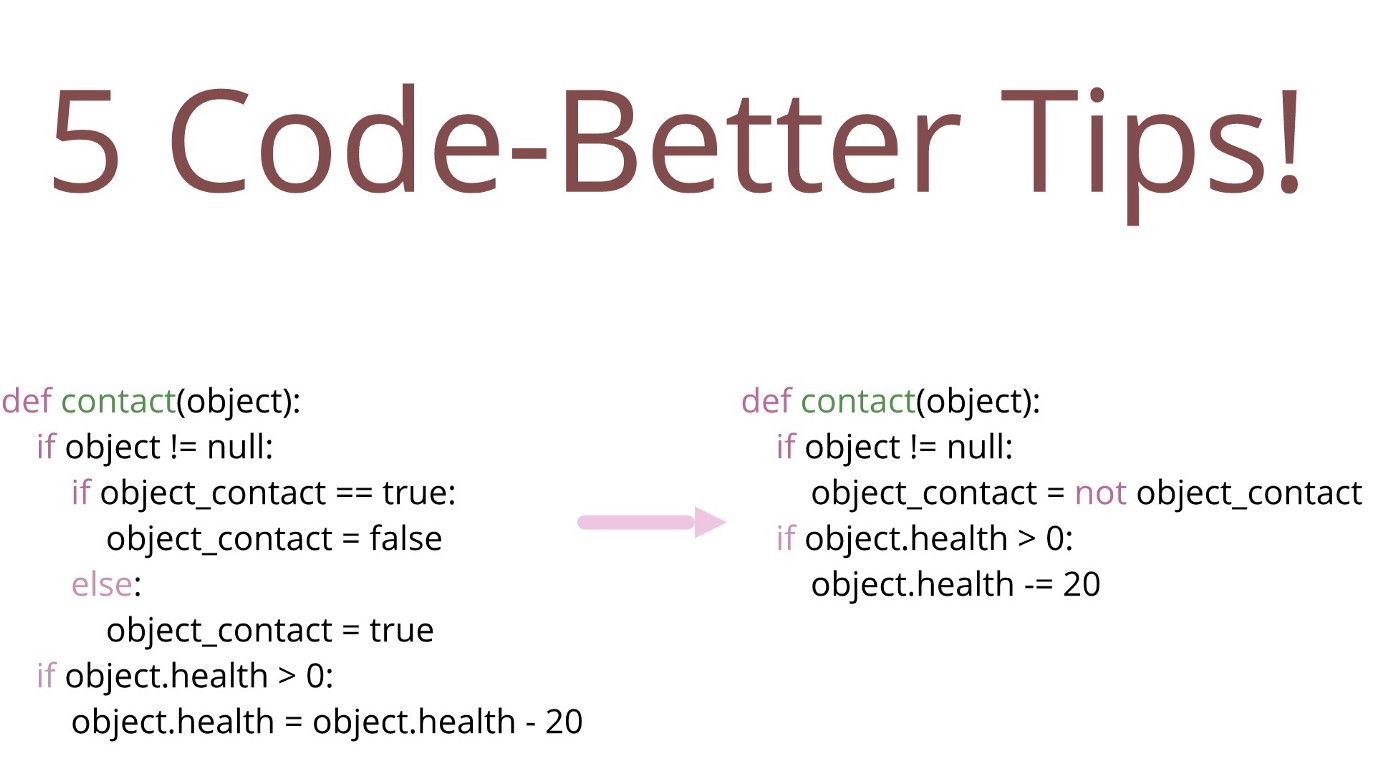